# BRAIN TUMOR DETECTION with VGG-16 MODEL

# Project Overview

Data citra yang digunakan untuk permasalahan ini adalah Citra MRI Otak untuk Deteksi Tumor Otak. Ini berisi pemindaian MRI dari dua kelas:
*   NO - no tumor, encoded as 0
*   YES - tumor, encoded as 1

Sayangnya, deskripsi kumpulan data tidak menyimpan informasi apa pun dari mana pemindaian MRI ini berasal.


## Apa itu Tumor Otak?

Tumor otak terjadi ketika sel-sel abnormal terbentuk di dalam otak. Ada dua jenis utama tumor: tumor kanker (ganas) dan tumor jinak. Tumor kanker dapat dibagi menjadi tumor primer, yang dimulai di dalam otak, dan tumor sekunder, yang telah menyebar dari tempat lain, yang dikenal sebagai tumor metastasis otak. Semua jenis tumor otak dapat menimbulkan gejala yang bervariasi tergantung pada bagian otak yang terkena. Gejala-gejala ini mungkin termasuk sakit kepala, kejang, masalah penglihatan, muntah, dan perubahan mental. Sakit kepala biasanya lebih buruk di pagi hari dan hilang dengan muntah. Gejala lain mungkin termasuk kesulitan berjalan, berbicara atau dengan sensasi. Seiring perkembangan penyakit, ketidaksadaran dapat terjadi.

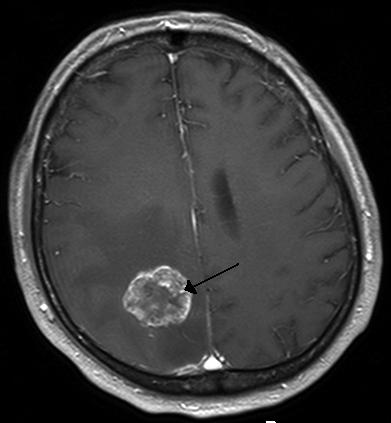

# IMPORT MODULE

In [1]:
# C:\Users\USER\.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syahmisajid12","key":"a76cee502ebc4268b9b384c1c587dfe1"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 99% 15.0M/15.1M [00:01<00:00, 22.3MB/s]
100% 15.1M/15.1M [00:01<00:00, 15.1MB/s]


In [4]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/Syahmi33github/Emotion-Classification/main/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, view_random_images,pred_and_plot, load_and_prep_image

--2023-06-13 12:57:39--  https://raw.githubusercontent.com/Syahmi33github/Emotion-Classification/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11485 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  11.22K  --.-KB/s    in 0s      

2023-06-13 12:57:39 (91.9 MB/s) - ‘helper_functions.py’ saved [11485/11485]



# Data Pre-Processing

In [5]:
unzip_data("/content/brain-mri-images-for-brain-tumor-detection.zip")

In [6]:
walk_through_dir("/content/brain_tumor_dataset")

There are 2 directories and 0 images in '/content/brain_tumor_dataset'.
There are 0 directories and 98 images in '/content/brain_tumor_dataset/no'.
There are 0 directories and 155 images in '/content/brain_tumor_dataset/yes'.


In [7]:
train_dir = '/content/brain_tumor_dataset/'

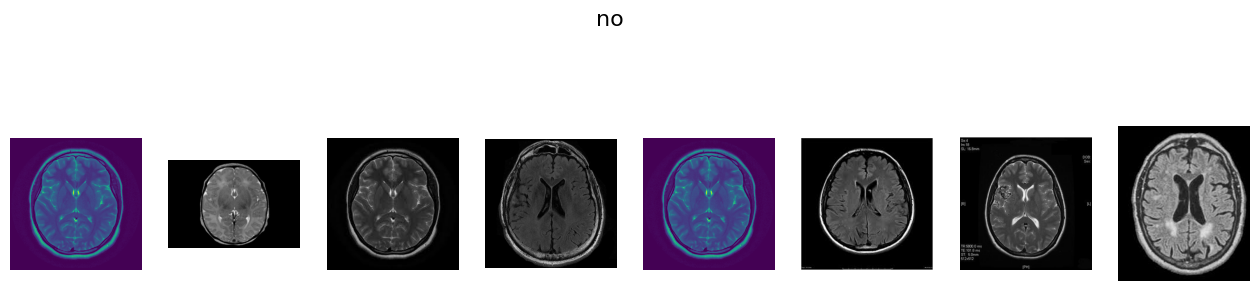

In [8]:
# View a random image from the training dataset
img = view_random_images(target_dir=train_dir,
                        target_class="no",
                        num_images = 8)

## Crop Image

In [9]:
import os
import cv2
import numpy as np

def crop_img(img, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = add_pixels_value
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

    return [new_img]

def crop_imgs_in_folder(original_folder, target_folder, add_pixels_value=0):
    """
    Finds the extreme points on the images in the original folder and crops the rectangular out of them,
    then saves the cropped images in the target folder.
    """
    # Membuat folder target jika belum ada
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Mendapatkan daftar file dalam folder asli
    files = os.listdir(original_folder)

    for file in files:
        # Mengabaikan file yang bukan gambar
        if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        # Baca gambar
        img_path = os.path.join(original_folder, file)
        img = cv2.imread(img_path)

        # Proses cropping gambar
        cropped_imgs = crop_img(img, add_pixels_value)

        # Simpan hasil cropping
        for i, cropped_img in enumerate(cropped_imgs):
            new_file = os.path.splitext(file)[0] + '_cropped_' + str(i) + os.path.splitext(file)[1]
            new_img_path = os.path.join(target_folder, new_file)
            cv2.imwrite(new_img_path, cropped_img)

    print("Proses cropping selesai.")

In [13]:
import os
import shutil
import random
import imutils

img = cv2.imread('/content/brain_tumor_dataset/no/20 no.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

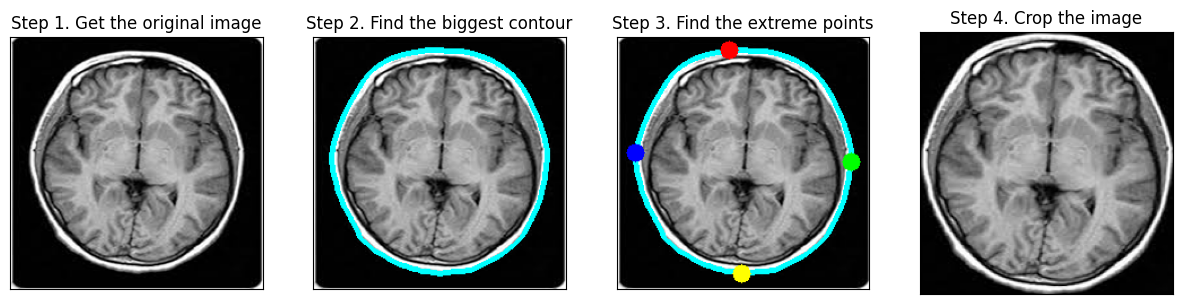

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [15]:
import os
import shutil
import random

# Path ke folder yang ingin Anda buat
folder_path = '/content/brain_tumor_crop'
folder_path_no = '/content/brain_tumor_crop/no'
folder_path_yes = '/content/brain_tumor_crop/yes'


# Membuat folder
os.makedirs(folder_path, exist_ok=True)
os.makedirs(folder_path_no, exist_ok=True)
os.makedirs(folder_path_yes, exist_ok=True)

print("Folder berhasil dibuat!")

Folder berhasil dibuat!


In [16]:
original_folder = '/content/brain_tumor_dataset/no/'
target_folder = '/content/brain_tumor_crop/no/'
add_pixels_value = 10

crop_imgs_in_folder(original_folder, target_folder)

Proses cropping selesai.


In [17]:
original_folder = '/content/brain_tumor_dataset/yes/'
target_folder = '/content/brain_tumor_crop/yes/'
add_pixels_value = 10

crop_imgs_in_folder(original_folder, target_folder)

Proses cropping selesai.


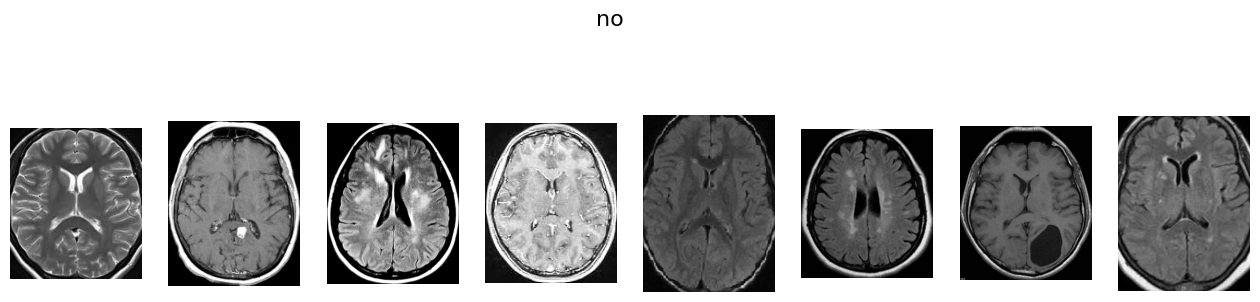

In [18]:
# View a random crop_image from the training dataset
img = view_random_images(target_dir='/content/brain_tumor_crop/',
                        target_class="no",
                        num_images = 8)

## SPLIT DATA

In [55]:
import os
import shutil
import random

# Path ke folder yang ingin Anda buat
folder_path = '/content/brain_tumor_split'

# Membuat folder
os.makedirs(folder_path, exist_ok=True)

print("Folder berhasil dibuat!")

Folder berhasil dibuat!


### DATA NO

In [19]:
# Path ke folder data
data_folder = '/content/brain_tumor_crop/no'
train_folder = '/content/brain_tumor_split/train_data/no'
test_folder = '/content/brain_tumor_split/test_data/no'
validation_folder = '/content/brain_tumor_split/validation_data/no'

# Pembagian persentase (train, test, validation)
train_percentage = 0.7
test_percentage = 0.03
validation_percentage = 0.17

# Membuat folder untuk set data
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)

# Mengambil daftar file dalam folder data
file_list = os.listdir(data_folder)

# Mengacak urutan file
random.shuffle(file_list)

# Menghitung jumlah file untuk masing-masing set data
total_files = len(file_list)
train_size = int(total_files * train_percentage)
test_size = int(total_files * test_percentage)
validation_size = total_files - train_size - test_size

# Memindahkan file ke set data masing-masing
for i, file_name in enumerate(file_list):
    file_path = os.path.join(data_folder, file_name)

    if i < train_size:
        destination_folder = train_folder
    elif i < train_size + test_size:
        destination_folder = test_folder
    else:
        destination_folder = validation_folder

    shutil.copy(file_path, destination_folder)

print("Pembagian data selesai!")
print(f"train = {train_size}")
print(f"test = {test_size}")
print(f"validation = {validation_size}")


Pembagian data selesai!
train = 68
test = 2
validation = 28


### DATA YES

In [20]:
import os
import shutil
import random

# Path ke folder data
data_folder = '/content/brain_tumor_crop/yes'
train_folder = '/content/brain_tumor_split/train_data/yes'
test_folder = '/content/brain_tumor_split/test_data/yes'
validation_folder = '/content/brain_tumor_split/validation_data/yes'

# Pembagian persentase (train, test, validation)
train_percentage = 0.8
test_percentage = 0.03
validation_percentage = 0.17

# Membuat folder untuk set data
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)

# Mengambil daftar file dalam folder data
file_list = os.listdir(data_folder)

# Mengacak urutan file
random.shuffle(file_list)

# Menghitung jumlah file untuk masing-masing set data
total_files = len(file_list)
train_size = int(total_files * train_percentage)
test_size = int(total_files * test_percentage)
validation_size = total_files - train_size - test_size

# Memindahkan file ke set data masing-masing
for i, file_name in enumerate(file_list):
    file_path = os.path.join(data_folder, file_name)

    if i < train_size:
        destination_folder = train_folder
    elif i < train_size + test_size:
        destination_folder = test_folder
    else:
        destination_folder = validation_folder

    shutil.copy(file_path, destination_folder)

print("Pembagian data selesai!")
print(f"train = {train_size}")
print(f"test = {test_size}")
print(f"validation = {validation_size}")


Pembagian data selesai!
train = 124
test = 4
validation = 27


In [21]:
walk_through_dir("/content/brain_tumor_split")

There are 3 directories and 0 images in '/content/brain_tumor_split'.
There are 2 directories and 0 images in '/content/brain_tumor_split/validation_data'.
There are 0 directories and 28 images in '/content/brain_tumor_split/validation_data/no'.
There are 0 directories and 27 images in '/content/brain_tumor_split/validation_data/yes'.
There are 2 directories and 0 images in '/content/brain_tumor_split/test_data'.
There are 0 directories and 2 images in '/content/brain_tumor_split/test_data/no'.
There are 0 directories and 4 images in '/content/brain_tumor_split/test_data/yes'.
There are 2 directories and 0 images in '/content/brain_tumor_split/train_data'.
There are 0 directories and 68 images in '/content/brain_tumor_split/train_data/no'.
There are 0 directories and 124 images in '/content/brain_tumor_split/train_data/yes'.


## Data Augmentasi

In [22]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/brain_tumor_split/train_data"
test_dir = "/content/brain_tumor_split/test_data"
validation_dir = "/content/brain_tumor_split/validation_data"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
validation_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Training images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

print("Testing images:")
validation_data = validation_datagen.flow_from_directory(validation_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 192 images belonging to 2 classes.
Training images:
Found 6 images belonging to 2 classes.
Testing images:
Found 55 images belonging to 2 classes.


# Model

## Model 0

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

inputs = Input(shape=(224, 224, 3))

x = Conv2D(16, 3, activation='relu')(inputs)
x = Conv2D(16, 3, activation='relu')(x)
x = MaxPool2D()(x)

x = Conv2D(32, 3, activation='relu')(inputs)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPool2D()(x)

x = Flatten()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_0 = Model(inputs=inputs, outputs=outputs)

model_0.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_0 = model_0.fit(train_data,
                        epochs=5,
                        # steps_per_epoch=len(train_data),
                        validation_data=validation_data,
                        # validation_steps=len(validation_data)
                        )

Epoch 1/5
6/6 [==============================] - 13s 297ms/step - loss: 1.3139 - accuracy: 0.5000 - val_loss: 0.8217 - val_accuracy: 0.5000
Epoch 2/5
6/6 [==============================] - 1s 260ms/step - loss: 0.7250 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
6/6 [==============================] - 1s 240ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
6/6 [==============================] - 1s 239ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
6/6 [==============================] - 1s 165ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


In [35]:
baseModel_result = model_0.evaluate(test_data)

1/1 [==============================] - 0s 335ms/step - loss: 0.6932 - accuracy: 0.5000


## Model 1 (Transfer Learning)

In [24]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [25]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model


In [26]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

### Resnet

In [27]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=50,
                                  steps_per_epoch=len(train_data),
                                  validation_data=validation_data,
                                  validation_steps=len(validation_data),
                                  callbacks=[early_stopping]
                                  )

Epoch 1/50
6/6 [==============================] - 10s 979ms/step - loss: 0.8404 - accuracy: 0.5469 - val_loss: 0.6797 - val_accuracy: 0.5818
Epoch 2/50
6/6 [==============================] - 1s 206ms/step - loss: 0.5435 - accuracy: 0.6823 - val_loss: 0.5640 - val_accuracy: 0.7091
Epoch 3/50
6/6 [==============================] - 1s 213ms/step - loss: 0.4238 - accuracy: 0.7604 - val_loss: 0.4266 - val_accuracy: 0.8364
Epoch 4/50
6/6 [==============================] - 1s 201ms/step - loss: 0.3388 - accuracy: 0.8542 - val_loss: 0.3555 - val_accuracy: 0.8727
Epoch 5/50
6/6 [==============================] - 1s 209ms/step - loss: 0.2947 - accuracy: 0.8906 - val_loss: 0.3142 - val_accuracy: 0.9273
Epoch 6/50
6/6 [==============================] - 1s 179ms/step - loss: 0.2610 - accuracy: 0.8906 - val_loss: 0.3171 - val_accuracy: 0.8727
Epoch 7/50
6/6 [==============================] - 2s 269ms/step - loss: 0.2291 - accuracy: 0.9167 - val_loss: 0.2699 - val_accuracy: 0.9273
Epoch 8/50
6/6 [===

In [29]:
resnet_result = resnet_model.evaluate(validation_data)

2/2 [==============================] - 0s 76ms/step - loss: 0.2211 - accuracy: 0.9091


### efficientnet

In [30]:
# Create model
efficientnet_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

# Compile
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data,
                                  epochs=50,
                                  steps_per_epoch=len(train_data),
                                  validation_data=validation_data,
                                  validation_steps=len(validation_data),
                                  callbacks=[early_stopping]
                                  )

Epoch 1/50
6/6 [==============================] - 15s 550ms/step - loss: 0.6954 - accuracy: 0.6406 - val_loss: 0.6267 - val_accuracy: 0.6727
Epoch 2/50
6/6 [==============================] - 1s 177ms/step - loss: 0.5544 - accuracy: 0.7448 - val_loss: 0.6237 - val_accuracy: 0.6182
Epoch 3/50
6/6 [==============================] - 1s 181ms/step - loss: 0.4813 - accuracy: 0.7760 - val_loss: 0.5924 - val_accuracy: 0.6364
Epoch 4/50
6/6 [==============================] - 1s 191ms/step - loss: 0.4335 - accuracy: 0.8229 - val_loss: 0.5141 - val_accuracy: 0.7818
Epoch 5/50
6/6 [==============================] - 1s 187ms/step - loss: 0.3949 - accuracy: 0.8594 - val_loss: 0.4850 - val_accuracy: 0.8000
Epoch 6/50
6/6 [==============================] - 1s 201ms/step - loss: 0.3643 - accuracy: 0.8698 - val_loss: 0.4612 - val_accuracy: 0.8364
Epoch 7/50
6/6 [==============================] - 2s 252ms/step - loss: 0.3409 - accuracy: 0.8698 - val_loss: 0.4368 - val_accuracy: 0.8364
Epoch 8/50
6/6 [===

In [32]:
efficientnet_result = efficientnet_model.evaluate(validation_data)

2/2 [==============================] - 0s 58ms/step - loss: 0.3164 - accuracy: 0.8545


# Evaluation

In [33]:
import pathlib
import numpy as np

data_dir = pathlib.Path("/content/brain_tumor_split/train_data") # turn our training path into a Python path
# class_names = np.array([item.name for item in data_dir.glob('*')]) # created a list of class_names from the subdirectories
class_names = np.array([item.name for item in sorted(data_dir.glob('*'))]) # created a list of class_names from the subdirectories
class_names

array(['no', 'yes'], dtype='<U3')

In [36]:
print(f"Akurasi Base Model = {baseModel_result[1]}")
print(f"Akurasi Resnet = {round(resnet_result[1],2)}")
print(f"Akurasi Efficientnet ={round(efficientnet_result[1],2)}")

Akurasi Base Model = 0.5
Akurasi Resnet = 0.91
Akurasi Efficientnet =0.85


1/1 [==============================] - 0s 24ms/step


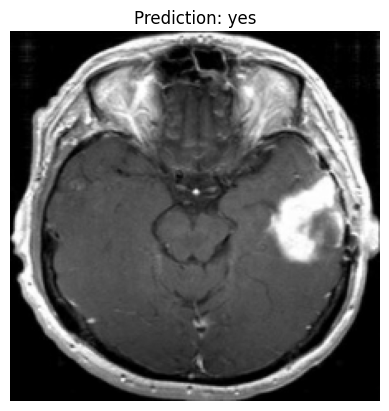

In [41]:
pred_and_plot(model=resnet_model,
              filename="/content/brain_tumor_split/test_data/yes/Y155_cropped_0.JPG",
              class_names=class_names)